# 4. Training Models

Treating algorithms as black boxes is definitely faster and it does the trick, but understand what is under the hood is essential to really have a firm grasp on our systems and being able to adapt them to what we need. 

In this section, we will :

1. Work on a Linear Regression model, training it using both a **closed-form** equation and **Gradient Descent**
2. Introduce **Polynomial regression**, useful for non-linear datasets but more prone to overfitting (regularization will be needed)
3. We will look at two more models commonly used for classification: **Logistic Regression** and **Softmax Regression**

## Linear regression

Generally, a linear model makes a prediction by simply computing a weighted sum of the **input features**, plus a constant called the **bias term** (also called the _intercept term_).

$y = \theta_0 + \theta_1x_1 + \theta_2x_2 + \cdots + \theta_nx_n$

Or, in vectorized form:

$y = h_{\theta}(x) = \theta \cdot x$

To train this model, what we want to do is **minimize the Mean Square Error (MSE)**:

$\text{MSE }(X, h_\theta) = \frac{1}{m} \sum^{m}_{i = 1}(\theta^T x^{(i)} - y^{(i)})^2$

#### Normal Equation

It is simply the _closed-form solution_ (an equation that computes the result directly without intermediate steps) for our minimization problem: 

$ \theta_{min} = (X^T X)^{-1} X^T y$ 

Example:

In [1]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [2]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [3]:
theta_best

array([[3.8239648 ],
       [3.14613997]])

In [4]:
# making predictions using theta_best

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.8239648 ],
       [10.11624473]])

In [5]:
from matplotlib import pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

<Figure size 640x480 with 1 Axes>

Now let's use Scikit-learn:

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.8239648]), array([[3.14613997]]))

In [7]:
lin_reg.predict(X_new)

array([[ 3.8239648 ],
       [10.11624473]])

### Gradient Descent

Gradient Descent is a very generic optimization algorithm capable of iteratively finding optimal solutions to a wide range of problems. 

Given its iterative approach, GD may run into issues when it comes to local/global minima. Luckily for us, the Linear Regression cost function is _convex_ (it only has one global minimum).   

**Note**: when using Gradient Descent, we should ensure that all features have a similar scale for faster convergence. 

#### Batch Gradient Descent

It's the most common implementation, going over the whole training set at each GD step. 

$ \theta_{\text{(next step)}} = \theta - \eta \nabla_{\theta} \text{MSE}(\theta)$

Python implementation:

In [8]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [9]:
theta

array([[3.8239648 ],
       [3.14613997]])

Same as our Normal Equation result above!

#### Stochastic Gradient Descent

Obviously, Batch Gradient Descent can get very slow for big datasets, since it is working on the whole training set. On the opposite of the spectrum, we have Stochastic GD, using a random instance in the training set at every step. 

Due to its stochastic nature, it has a better chance to find global optima for functions which are not strictly convex, but it is also not bound to settle for any specific minimum, but rather staying in a "good enough" area.

A solution to this dilemma may be to gradually decrease the learning rate (according to a **learning schedule**). 

In [10]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [11]:
theta

array([[3.80709325],
       [3.14798832]])

Pretty good, but not optimal.

**Note**: When using Stochastic Gradient Descent, the training instances must be independent and identically distributed (IID), to ensure that the parameters get pulled towards the global optimum, on average. A simple way to ensure this is to **shuffle the instances during training**.

Example:

In [12]:
from sklearn.linear_model import SGDRegressor # Stochastic Gradient Descent Regressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([3.79474325]), array([3.13569893]))

#### Mini-batch Gradient Descent 

The middle way. Instead of going full-training-set (Batch) or one-instance-only (Stochastic) Mini-batch GD computes the gradients on small random sets of instances called _... drum rolls..._ mini-batches.

To conclude, here is a summary table for the different algorithms available for Linear Regression:

![Comparison Table of algorithms for Linear Regression](images/4.Lin_Reg_algos_comparison.jpg)

### Polynomial Regression

We can also use linear models to fit nonlinear data by adding powers of each feature as new features, then train a linear model on this extended set of features. This technique is called **Polynomial Regression**.

Example:

In [13]:
# generating non-linear (quadratic) data

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

We can now use Scikit-Learn’s `PolynomialFeatures` class to transform our training data, adding the square of each feature in the training set as new features.

In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False) # excluding bias term
X_poly = poly_features.fit_transform(X)
X[0]

array([0.20044472])

In [15]:
X_poly[0] # original feature + squared feature

array([0.20044472, 0.04017809])

We can now fit a Linear Regression to this extended training data:

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.14296606]), array([[0.94808845, 0.46664261]]))

**Note**: Given **n** features, `PolynomialFeatures(degree=d)` returns an array of $\displaystyle \frac{(n + d)!}{d!n!}$

### Learning Curves

A standard way to understand if our model is under/overfitting the data is to look at the learning curves: plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration).

Generally speaking:

1. Converging + high error = **underfitting**
2. Not converging + lower error = **overfitting** (adding more data can help)

**Note**: A model’s generalization error can be expressed as the sum of three different errors:

1. **Bias**: due to wrong assumptions > likely to underfitting

2. **Variance**: due to excessive sensitivity to small variations in the training data > likely to overfit

3. **Irreducible error**: due to the intrinsic noisiness of the data > we can reduce it by cleaning up the data (broken sources, outliers, etc.)

### Regularized Linear Models

For a linear model, regularization is typically achieved by constraining the weights of the model.

Let's look at three different ways on how this can be achieved：

#### Ridge Regression

A regularization term $\alpha \sum_{i = 1}^n \theta^2_i$ is added to the cost function we are trying to minimize: $J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum^n_{i=1} \theta^2_i$

**Note 1**: the regularization term should only be added to the cost function during training.  
**Note 2**: Remember to scale the data before performing regularization.

#### Lasso Regression

Shorter for _Least Absolute Shrinkage and Selection Operator Regression_. It uses the $l_1$ norm of the weight vector instead of half the square of the $l_2$ norm: $J(\theta) = MSE(\theta) + \alpha\sum^n_{i=1} | \theta_i |$

An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the least important features (i.e., set them to zero).  
In other words, Lasso Regression automatically performs feature selection and outputs a **sparse model** (i.e., with few nonzero feature weights).

#### Elastic Net

It's a mix of Ridge and Lasso, which we can control with a parameter $r$: 
* r = 0 > Ridge Regression
* r = 1 > Lasso Regression

$J(\theta) = MSE(\theta) + r\alpha\sum^n_{i=1} |\theta_i| + \frac{1-r}{2} \alpha \sum^n_{i=1} \theta^2_i$

#### How to choose a Linear Model

Two general tips:

1. **Ridge** is a good default, but if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net

2. **Elastic Net** is preferred over Lasso since Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated

#### Early stopping

We can also decide to stop GD as soon as it reaches a certain error level. This may be particularly helpful in complex models where the **validation error** stops decreasing and actually starts to go back up.  

For Stochastic or Mini-Batch GD, since they are not _smooth_, we may want to stop only after the error has been under the minimimum for a certain number of epochs. 

## Logistic Regression



Logistic Regression (also called _Logit Regression_) is commonly used to estimate the probability that an instance belongs to a particular class.  
If the probability is above a certain **threshold**, the model predicts that the instance belongs to that class making Logistic Regression a **binary classifier**. 

A Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the **logistic** of this result:

$p = h_{\theta}(x) = \sigma(x^T \theta)$

Where $\sigma$ is a sigmoid function which outputs a number between 0 and 1:

$\displaystyle \sigma(t) = \frac{1}{1+ exp(-t)}$

### Cost Function

Here is our _log loss_:

$J(\theta) = -\frac{1}{m} \sum^m_{i=1} [y^{(i)} log(p^{(i)}) + (1-y^{(i)}) log (1-p^{(i)})]$

#### Decision Boundaries

Let's build a classifier to detect the Iris-Virginica using a well-known dataset and Logistic Regression:

In [4]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [5]:
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(np.int) # 1 if Iris-Virginica, else 0

In [8]:
# training our Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

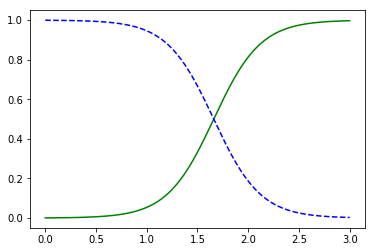

In [11]:
# estimated probs

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")

We can see here how the most "confident" predictions are at the edges of the graph, while the center values (around 1.6 cm) are where the uncertainty is the highest (both around 50%).  

**Note**: hyperparameter for regularization of Log Reg is not `alpha` but $\frac{1}{\alpha} =$ `C` . Higher C > Less regularized the model. 

### Softmax Regression

Its other name (Multinomial Logistic Regression) basically explains what is it, a Log Reg generalized to multiple classes.